In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

## MobileNet-V2

#### Imports

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import torchvision.models as models

#### Hyperparameters

In [3]:
batch_size = 128
num_epochs = 5
learning_rate = 0.01

transform = transforms.Compose(
  [transforms.Resize((224, 224)), # Resize images to 224x224 pixels
  transforms.ToTensor(), # Convert images to tensors
  transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))]) # Normalize images

#### Train-Validation-Test Sets

In [4]:
TRAIN_PATH = "/kaggle/input/intel-image-classification/seg_train/seg_train"
trainset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transform)

validation_size = int(0.05 * len(trainset))
training_size = len(trainset) - validation_size

trainset , validationset = torch.utils.data.random_split(trainset, [training_size,validation_size]) 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
print(f"Training Set Images : {len(trainset)}")

validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=True)
print(f"Training Set Images : {len(validationset)}")

Training Set Images : 13333
Training Set Images : 701


In [5]:
TEST_PATH = "/kaggle/input/intel-image-classification/seg_test/seg_test"
testset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
print(f"Testing Set Images : {len(testset)}")

Testing Set Images : 3000


#### Activate GPU

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Fine-Tune

In [7]:
mobilenet = models.mobilenet_v2(pretrained=True)

# Setting up final layer (6 Classes)
num_classes = 6
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, num_classes)

# optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=learning_rate)

mobilenet.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

#### Training

In [8]:
train_losses = []
train_accuracies = []

# Training Mode : On
mobilenet.train()  
    
for epoch in range(num_epochs):
    
    print(f"\n\nProcessing Epoch : {epoch + 1}")
    
    running_loss = 0.0
    running_acc = 0.0
    
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = mobilenet(inputs).to(device)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == labels).item() / batch_size
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_acc += acc
        
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss / 50, running_acc / 50))
            running_loss = 0.0
            running_acc = 0.0

    # Calculate training loss and accuracy for the epoch
    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_acc = running_acc / len(trainloader)
    
    # Append training loss and accuracy to the lists
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)



Processing Epoch : 1
[1,    50] loss: 1.610 acc: 0.403
[1,   100] loss: 0.958 acc: 0.573


Processing Epoch : 2
[2,    50] loss: 0.755 acc: 0.705
[2,   100] loss: 0.644 acc: 0.762


Processing Epoch : 3
[3,    50] loss: 0.576 acc: 0.794
[3,   100] loss: 0.510 acc: 0.818


Processing Epoch : 4
[4,    50] loss: 0.485 acc: 0.823
[4,   100] loss: 0.442 acc: 0.842


Processing Epoch : 5
[5,    50] loss: 0.457 acc: 0.838
[5,   100] loss: 0.476 acc: 0.833


#### Validating

In [9]:
val_losses = []
val_accuracies = []

# Evaluation Mode : On
mobilenet.eval()  

with torch.no_grad():
    for data in validationloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == labels).item() / batch_size

        # Append validation loss and accuracy to the lists
        val_losses.append(loss.item())
        val_accuracies.append(acc)

print('Loss: %.3f , Accuracy: %.3f' % (np.mean(val_losses), np.mean(val_accuracies) * 100))

Loss: 0.485 , Accuracy: 76.693


#### Testing

In [10]:
test_losses = []
test_accuracies = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == labels).item() / batch_size

        # Append test loss and accuracy to the lists
        test_losses.append(loss.item())
        test_accuracies.append(acc)

print('Test Loss: %.3f Test Accuracy: %.3f' % (np.mean(test_losses), np.mean(test_accuracies) * 100))

Test Loss: 0.474 Test Accuracy: 81.478


#### Visualization

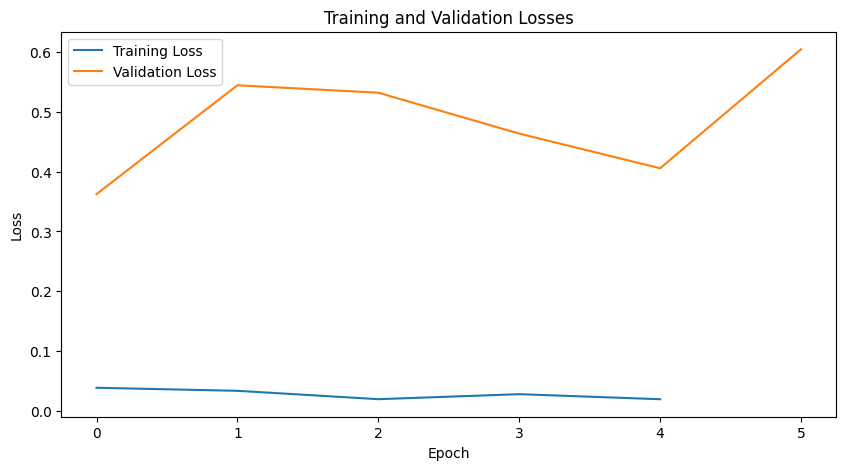

In [11]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Training and Validation Losses')
plt.legend()

plt.show()

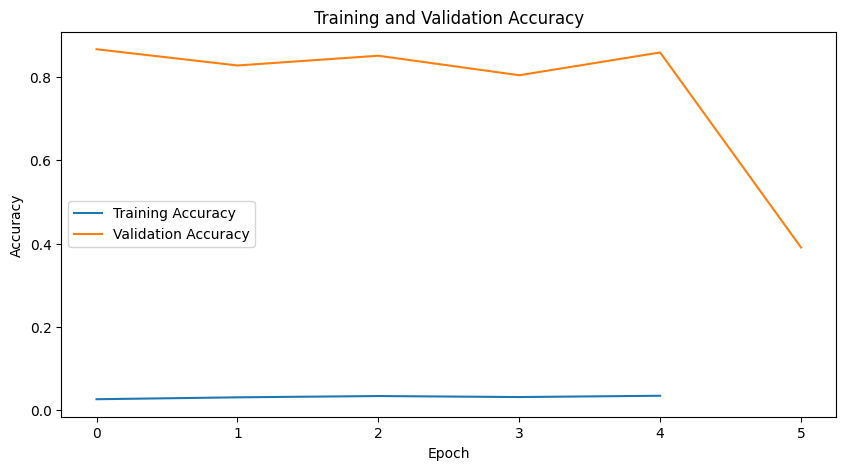

In [12]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()